In [140]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils

## For modeling ###
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization
from keras. callbacks import EarlyStopping
from keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adamax
from sklearn.model_selection import train_test_split

In [141]:
df = pd.read_csv('EGFR_3.csv')
df = df.sample(frac=1).reset_index(drop=True)
df


,Age,Age_normalized,Sex,smoking,survival,sur_time_mo,prog_time_mo,VDW,EEL,EGB,...,EEL.1,EPB,ENPOLAR,TOTAL.1,Matching_rates,Centroid_distance,Connectivity,Convex_atoms,Hydrogen_bonds,response
0,48,1,1,0,0,3.420,3.42,-51.9583,-17.1889,35.8271,...,-17.1889,37.3161,-35.0457,-66.8767,0.4136,48.25,22.186,25,1450,partial
1,76,4,1,0,1,1.380,0.95,-51.9583,-17.1889,35.8271,...,-17.1889,37.3161,-35.0457,-66.8767,0.4136,48.25,15.186,31,1450,no
2,81,4,1,0,0,2.070,2.07,-51.9583,-17.1889,35.8271,...,-17.1889,37.3161,-35.0457,-66.8767,0.4136,48.25,22.186,23,1450,partial
3,54,2,0,0,0,18.860,18.86,-51.9140,-26.6512,39.3616,...,-26.6512,38.5811,-36.8522,-76.8363,0.4136,48.25,22.186,28,1450,partial
4,71,4,1,2,0,0.667,1.00,-45.7159,-12.8403,30.1702,...,-12.0850,40.2891,-32.0103,-35.0310,0.2634,49.45,14.464,21,910,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,76,4,1,1,1,0.950,0.89,-50.1603,-19.8216,36.7352,...,-19.8216,41.8836,-33.8104,-61.9088,0.4135,48.55,16.513,48,1650,no
197,48,1,0,2,1,3.250,1.16,-51.0018,-29.4648,42.4027,...,-29.4648,41.0202,-36.7985,-76.2450,0.3525,55.15,14.089,35,775,no
198,71,4,1,0,1,17.680,12.22,-48.5144,-8.1678,29.8761,...,-8.1678,39.0625,-33.2823,-50.9020,0.4135,48.55,21.535,26,1650,partial
199,80,4,1,0,1,1.680,1.61,-51.0018,-29.4648,42.4027,...,-29.4648,41.0202,-36.7985,-76.2450,0.2876,58.55,14.517,49,996,no


In [142]:
X = df.drop(['Age', 'response', 'EEL',  'VDW', 'EPB', 'ENPOLAR'], axis = 1)
y = df['response']
X.shape

(201, 17)

In [143]:
normalized_df=(X-X.mean())/X.std()
X = np.array(normalized_df)
X.dtype


dtype('float64')

In [144]:
X_p = normalized_df[["Age_normalized", "Sex", "survival", "sur_time_mo"]]
X_p = np.array(X_p)
X_p.dtype
X_e = normalized_df[["EGB", "TOTAL", "ESURF", "EEL.1"]]
X_e = np.array(X_e)
X_e.shape
X_g1 = normalized_df[["Matching_rates", "Connectivity", "Hydrogen_bonds"]]
X_g1 = np.array(X_g1)
X_g2 = normalized_df[["Convex_atoms", "Centroid_distance"]]
X_g2 = np.array(X_g2)
X_total = np.concatenate((X_p, X_e, X_g1, X_g2), axis = 1)
X_totalep = np.concatenate((X_p, X_e), axis = 1)
X_totaleg = np.concatenate((X_e, X_g1, X_g2), axis = 1)
X_totalpg = np.concatenate((X_p, X_g1, X_g2), axis = 1)
X_totalg = np.concatenate((X_g1, X_g2), axis = 1)



X_total.shape

(201, 13)

In [145]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_total, y, test_size=0.30, random_state=42)


In [146]:
# one - hot encoding Y
encoder =  LabelEncoder()
encoder.fit(Y_train)
encoded_y_train = encoder.transform(Y_train)
dummy_y_train = np_utils.to_categorical(encoded_y_train)
dummy_y_train.dtype
dummy_y_train.shape
# One-hot encoding Test
encoder_test = LabelEncoder()
encoder.fit(Y_test)
encoded_y_test = encoder.transform(Y_test)
dummy_y_test = np_utils.to_categorical(encoded_y_test)
dummy_y_test.shape

(61, 4)

Mean Value 0.7785714285714286


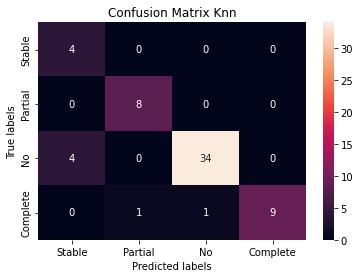

In [147]:
## Knn classifier with 10 fold cross valiadtion
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneOut
standardizer = StandardScaler()
knn = KNeighborsClassifier(n_neighbors=5)
pipe = Pipeline([("standadrdizer", standardizer), ("knn", knn)])
search_space = [{"knn__n_neighbors": [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]}]
grid_search = GridSearchCV(
  pipe,
	search_space,
	cv=5, 
  verbose=0)
#model = grid_search.fit(features_standardized, target)
model = grid_search.fit(X_train, Y_train)
cv =LeaveOneOut()               
cv_score = cross_val_score(model, X_train, Y_train, cv = cv)
print('Mean Value', cv_score.mean())
#print(grid_search.score())
ypred = model.predict(X_test)
matrix = confusion_matrix(Y_test, ypred)
matrix
encoder =  LabelEncoder()
encoder.fit(ypred)
encoded_y_pred = encoder.transform(ypred)
dummy_y_predsvm = np_utils.to_categorical(encoded_y_pred)
#plt.subplot(1, 2, 1) # row 1, col 2 index 1
#ax1= plt.subplot(1, 2, 1)
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix Knn'); 
ax.xaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']); 
ax.yaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']);
#plt.subplot(1, 2, 2)
#ax2= plt.subplot(1, 2, 2)
#sns.heatmap(matrix, annot=True, fmt='g', ax=ax2);  #annot=True to annotate cells, ftm='g' to disable scientific notation
#ax= plt.subplot()
#ax2.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax2.set_title('Confusion Matrix Knn'); 
#ax2.xaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']); 
#ax2.yaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']);
#ax= plt.subplot()
#clf_report_knn = classification_report(dummy_y_test.argmax(axis=1), dummy_y_predsvm.argmax(axis=1), labels=[0, 1, 2 ,3], target_names=['Stable', 'Partial', 'No', 'Complete'], output_dict=True)
#sns.heatmap(pd.DataFrame(clf_report_knn).iloc[:-1, :].T, annot=True)
#ax.set_title('Classification Report Knn'); 
#fig, ax = plt.subplots(1,2)
#sns.heatmap(matrix, annot=True, fmt='g', ax=ax[0])  # plot1
#sns.heatmap(clf_report_knn, annot=True, fmt='g' ax=ax[1])  # plot2
#fig.show()
#from sklearn.model_selection import GridSearchCV
#create new a knn model
#knn2 = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
#param_grid = {‘n_neighbors’: np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
#knn_gscv = GridSearchCV(knn2, param_grid, cv=5)
#fit model to data
#knn_gscv.fit(X_train, dummy_y_train)

#print(cv_score)
#print('Mean Value', cv_score.mean())
#ypred=knn_cv.predict(X_test)
#matrix = confusion_matrix(dummy_y_test.argmax(axis=1), ypred.argmax(axis=1))
#import seaborn as sns
#import matplotlib.pyplot as plt     
#ax= plt.subplot()
#cm = confusion_matrix(dummy_y_test.argmax(axis=1), ypred.argmax(axis=1))
#sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
#ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix'); 
#ax.xaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']); ax.yaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']);


cross_val_score 0.95


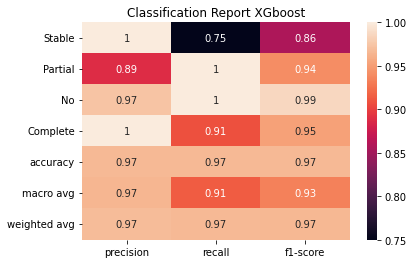

In [175]:
# Using XGBoost method
import xgboost
from sklearn.model_selection import cross_val_predict
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut

model = xgboost.XGBClassifier()
encoder =  LabelEncoder()
encoder.fit(Y_train)
encoded_y_train = encoder.transform(Y_train)
dummy_y_train = np_utils.to_categorical(encoded_y_train)
from sklearn.model_selection import LeaveOneOut
label_encoder = LabelEncoder()
label_encoder = label_encoder.fit(Y_train)
label_encoded_y = label_encoder.transform(Y_train)
model.fit(X_train, label_encoded_y)
label_encoder1 = label_encoder.fit(Y_test)
label_encoded_y1 = label_encoder1.transform(Y_test)
xgb=XGBClassifier(colsample_bytree=0.8, learning_rate=0.4, max_depth=4)
cv =LeaveOneOut()
cvs= cross_val_score(model, X_train, label_encoded_y, scoring = 'accuracy', cv=cv)
print('cross_val_score',cvs.mean())
pred = model.predict(X_test)
y_pred = cross_val_predict(xgb, X_test, Y_test, cv = cv)
matrix = confusion_matrix(Y_test, y_pred)
ax= plt.subplot()
#sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
#matrix = confusion_matrix(dummy_y_test.argmax(axis=1), dummy_y_pred.argmax(axis=1))
#y_pred
#print(model)

#ax.set_title('Confusion Matrix XGboost');
#y_pred = model.predict(X_test)
#pred = [round(value) for value in pred]
#accuracy = accuracy_score(label_encoded_y1, pred)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))

#matrix = confusion_matrix(label_encoded_y1, pred)
#predictions
#disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
#disp.plot()
#plt.show()
encoder =  LabelEncoder()
encoder.fit(y_pred)
encoded_y_pred = encoder.transform(y_pred)
dummy_y_pred = np_utils.to_categorical(encoded_y_pred)
clf_report_knn = classification_report(dummy_y_test.argmax(axis=1), dummy_y_pred.argmax(axis=1), labels=[0, 1, 2 ,3], target_names=['Stable', 'Partial', 'No', 'Complete'], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report_knn).iloc[:-1, :].T, annot=True)
ax.set_title('Classification Report XGboost'); 
#ax.set_xlabel('Predicted labels');
#ax.set_ylabel('True labels'); 
#ax.xaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']); ax.yaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']);
#ax.set_title('Classification Report XGboost'); 
#y_pred

cross_val_score 0.7785714285714286


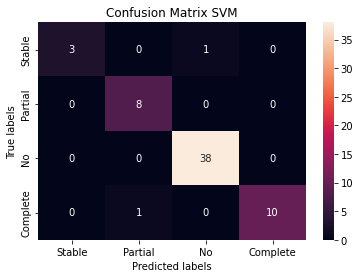

In [149]:
# Using SVM method
from sklearn import svm, datasets
import sklearn.model_selection as model_selection
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
rbf = svm.SVC(kernel='rbf', gamma=0.5, C=1).fit(X_train, Y_train)
poly = svm.SVC(kernel='poly', degree=3, C=1).fit(X_train, Y_train)
poly_pred = poly.predict(X_test)
rbf_pred = rbf.predict(X_test)
cvs= cross_val_score(poly, X_train, Y_train, scoring = 'accuracy', cv=cv)
print('cross_val_score',cvs.mean())
#matrix = confusion_matrix(Y_test, rbf_pred)
ax= plt.subplot()
sns.heatmap(matrix, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.xaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']); ax.yaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']);
ax.set_title('Confusion Matrix SVM');
encoder =  LabelEncoder()
encoder.fit(rbf_pred)
encoded_y_pred = encoder.transform(rbf_pred)
dummy_y_predsvm = np_utils.to_categorical(encoded_y_pred)

#clf_report_svm = classification_report(dummy_y_test.argmax(axis=1), dummy_y_predsvm.argmax(axis=1), labels=[0, 1, 2 ,3], target_names=['Stable', 'Partial', 'No', 'Complete'], output_dict=True)
#sns.heatmap(pd.DataFrame(clf_report_svm).iloc[:-1, :].T, annot=True)
#ax.set_title('Classification Report SVM'); 


cross_val_score 0.9214285714285714


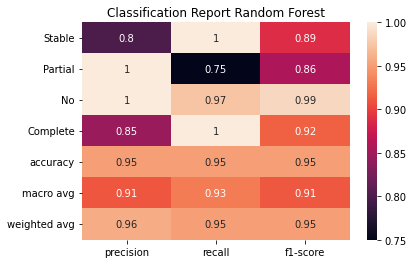

In [151]:
from sklearn.ensemble import RandomForestClassifier
cv =LeaveOneOut()
classifier = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 42)
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
 # Number of features to consider at every split
#max_features = ['auto', 'sqrt']
 #Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
#max_depth.append(None)
#max_depth.append(None)
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
#min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
#bootstrap = [True, False]
# Create the random grid
#random_grid = {'n_estimators': n_estimators,
 #              'max_features': max_features,
  #             'max_depth': max_depth,
   #            'min_samples_split': min_samples_split,
    #           'min_samples_leaf': min_samples_leaf,
     #          'bootstrap': bootstrap}
#print(random_grid)
#{'bootstrap': [True, False],
 #'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 #'max_features': ['auto', 'sqrt'],
 #'min_samples_leaf': [1, 2, 4],
 #'min_samples_split': [2, 5, 10],
 #'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
 # Use the random grid to search for best hyperparameters
#First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
#rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf.fit(X_train, Y_train)
#classifier.fit(X_train, dummy_y_train)
cvs= cross_val_score(rf, X_train, label_encoded_y, scoring = 'accuracy', cv=cv)
print('cross_val_score',cvs.mean())
predrf = rf.predict(X_test)
matrixrf = confusion_matrix(Y_test, predrf)
ax= plt.subplot()
#sns.heatmap(matrixrf, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
#matrix = confusion_matrix(dummy_y_test.argmax(axis=1), dummy_y_pred.argmax(axis=1))
#sns.heatmap(pd.DataFrame(clf_report_knn).iloc[:-1, :].T, annot=True)
#ax.set_title('Confusion Matrix Random Forest'); 
#ax.set_xlabel('Predicted labels');
#ax.set_ylabel('True labels'); 
#ax.xaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']); ax.yaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']);
# Look at parameters used by our current forest
#print('Parameters currently in use:\n')
#print(classifier.get_params())
encoder =  LabelEncoder()
encoder.fit(predrf)
encoded_y_pred = encoder.transform(predrf)
dummy_y_predrf = np_utils.to_categorical(encoded_y_pred)
#ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax.set_title('Classification Report Random Forest'); 
#ax.xaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']); 
#ax.yaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']);
clf_report_knn = classification_report(dummy_y_test.argmax(axis=1), dummy_y_predrf.argmax(axis=1), labels=[0, 1, 2 ,3], target_names=['Stable', 'Partial', 'No', 'Complete'], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report_knn).iloc[:-1, :].T, annot=True)
ax.set_title('Classification Report Random Forest'); 


In [152]:
# build the model
model = Sequential()
model.add(Dense(16, input_shape =(X_train.shape[1],), activation = 'sigmoid'))
model.add(Dense(36, activation='sigmoid'))
model.add(Dense(36, activation='sigmoid'))
#model.add(Dense(36, activation='sigmoid'))
model.add(Dense(12, activation='sigmoid'))
model.add(Dense(4, activation = 'softmax'))
model.summary()
from keras.utils.vis_utils import plot_model



Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_40 (Dense)            (None, 16)                96        
                                                                 
 dense_41 (Dense)            (None, 36)                612       
                                                                 
 dense_42 (Dense)            (None, 36)                1332      
                                                                 
 dense_43 (Dense)            (None, 12)                444       
                                                                 
 dense_44 (Dense)            (None, 4)                 52        
                                                                 
Total params: 2,536
Trainable params: 2,536
Non-trainable params: 0
_________________________________________________________________


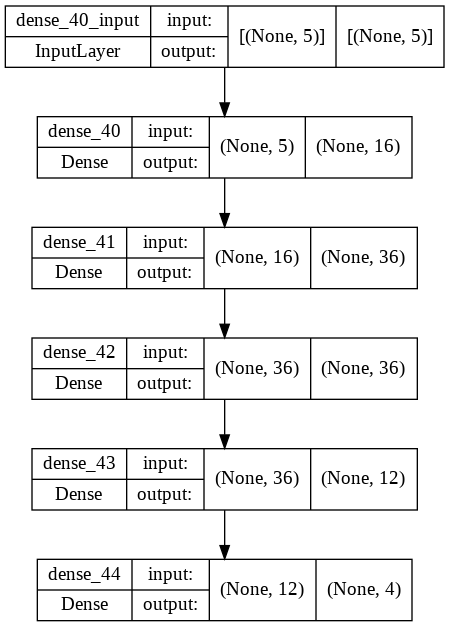

In [153]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model_plot.png', show_shapes=True, show_layer_names=True)

In [154]:
# Model compilation 
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [155]:
import keras
from keras.callbacks import EarlyStopping


In [156]:
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs. 
es = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                   mode = 'min',
                                   patience = 100,
                                   restore_best_weights = True,
                                   verbose= 1)

In [157]:
# now we just update our model fit call
history = model.fit(X_train,
                    dummy_y_train,
                    callbacks = [es],
                    epochs = 8000000,
                    batch_size = 5,
                    shuffle = True,
                    validation_split = 0.10,
                    verbose=1)

Epoch 1/8000000
26/26 [==============================] - 1s 9ms/step - loss: 1.4022 - accuracy: 0.2857 - val_loss: 1.2897 - val_accuracy: 0.5714
Epoch 2/8000000
26/26 [==============================] - 0s 3ms/step - loss: 1.2574 - accuracy: 0.5714 - val_loss: 1.2163 - val_accuracy: 0.5714
Epoch 3/8000000
26/26 [==============================] - 0s 3ms/step - loss: 1.1996 - accuracy: 0.5714 - val_loss: 1.1751 - val_accuracy: 0.5714
Epoch 4/8000000
26/26 [==============================] - 0s 2ms/step - loss: 1.1689 - accuracy: 0.5714 - val_loss: 1.1591 - val_accuracy: 0.5714
Epoch 5/8000000
26/26 [==============================] - 0s 3ms/step - loss: 1.1554 - accuracy: 0.5714 - val_loss: 1.1536 - val_accuracy: 0.5714
Epoch 6/8000000
26/26 [==============================] - 0s 3ms/step - loss: 1.1499 - accuracy: 0.5714 - val_loss: 1.1520 - val_accuracy: 0.5714
Epoch 7/8000000
26/26 [==============================] - 0s 3ms/step - loss: 1.1450 - accuracy: 0.5714 - val_loss: 1.1541 - val_ac

In [158]:
# learning curve
# accuracy
history_dict = history.history
acc = history_dict['accuracy']
val_acc=history_dict['val_accuracy']


In [159]:
# loss
loss = history_dict['loss']
val_loss = history_dict['val_loss']
# range of X (no. of epochs)
epochs = range(1, len(acc)+1)

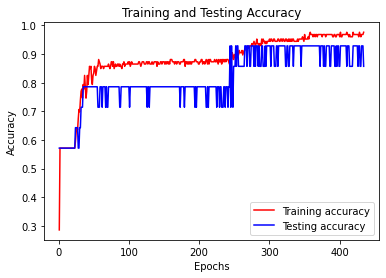

In [160]:
# plot
# "r" is for "solid red line"
import matplotlib.pyplot as plt
plt.plot(epochs, acc, 'r', label = 'Training accuracy')
plt.plot(epochs, val_acc, 'b', label = 'Testing accuracy')
plt.title('Training and Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

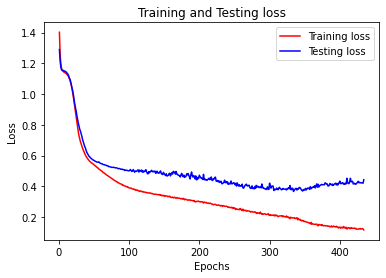

In [161]:
# plot
# "r" is for "solid red line"
plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'Testing loss')
plt.title('Training and Testing loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [162]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
preds = model.predict(X_test)
print(preds[0])
print(np.sum(preds[2]))

[3.1401020e-02 3.0810247e-07 9.5725155e-01 1.1347112e-02]
1.0


In [163]:
matrix = confusion_matrix(dummy_y_test.argmax(axis=1), preds.argmax(axis=1))
matrix

array([[ 4,  0,  0,  0],
       [ 0,  5,  0,  3],
       [ 0,  0, 38,  0],
       [ 0,  0,  0, 11]])

In [121]:
print(classification_report(dummy_y_test.argmax(axis=1), preds.argmax(axis=1)))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.86      0.86      0.86         7
           2       0.91      1.00      0.95        39
           3       0.91      0.83      0.87        12

    accuracy                           0.90        61
   macro avg       0.67      0.67      0.67        61
weighted avg       0.86      0.90      0.88        61



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


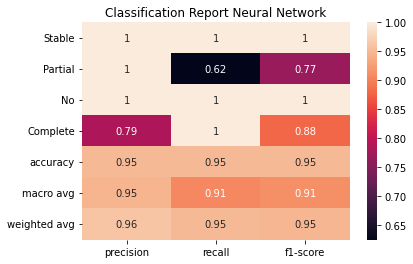

In [164]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
import seaborn as sns
import matplotlib.pyplot as plt     
ax= plt.subplot()
#cm = confusion_matrix(dummy_y_test.argmax(axis=1), preds.argmax(axis=1))
#sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
#ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix Neural Network'); 
#ax.xaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']); ax.yaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']);
#sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
#ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
#ax.set_title('Confusion Matrix Neural Network'); 
#ax.xaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']); ax.yaxis.set_ticklabels(['Stable', 'Partial', 'No', 'Complete']);



#disp = ConfusionMatrixDisplay(confusion_matrix=cm)
#disp.plot()
#plt.show()
clf_report_nn = classification_report(dummy_y_test.argmax(axis=1), preds.argmax(axis=1), labels=[0, 1, 2 ,3], target_names=['Stable', 'Partial', 'No', 'Complete'], output_dict=True)
sns.heatmap(pd.DataFrame(clf_report_nn).iloc[:-1, :].T, annot=True)
ax.set_title('Classification Report Neural Network'); 


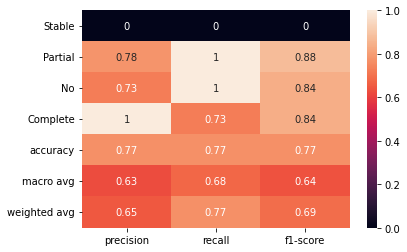

In [ ]:
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
sns.heatmap(pd.DataFrame(clf_report_knn).iloc[:-1, :].T, annot=True)